# Week 7 Time Series Classification
## Time Series Analysis
### Earnest Salgado
### ID 12285784

In [2]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sktime.forecasting.all import ForecastingHorizon
from sktime.forecasting.all import ExponentialSmoothing
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifierCV, ElasticNetCV, LassoLarsCV
from sktime.datasets import load_acsf1
from sktime.transformations.panel.rocket import Rocket, MiniRocket

import warnings
warnings.filterwarnings('ignore')

## Part 1: 35 pts Understanding the dataset

### Locate the dataset description within the full UCR data repository. (https://timeseriesclassification.com/dataset.php)

### 1.A. 7pts Give a verbal description of the dataset from information on the acsf1 detailed webpage, not the summary repository page.

- The data is from ACS-F1, which stands for the first version of the database of appliance consumption signatures. The dataset contains the power consumption of typical appliances. 
- The consumption patterns are mostly long idle periods with a few high bursts of enery consumption when the appliance is active. 
- The classes correspond to 10 categories of home appliances: mobile phones (via chargers), coffee machines, computer stations (including monitor), fridges and freezers, Hi-Fi systems (CD players), lamp (CFL), laptops (via chargers), microwave ovens, printers, and televisions (LCD or LED). There is nothing to infer from the order of examples in the train and test set. Data created by Gisler, Christophe, et al. 
 - Trainsize: 100
 - Test size: 100
 - Length: 1460
 - Num of classes: 10

### 1.B - 7pts There are 1460 time steps in each observation. Use len() to display this for any observation in the X_train

In [9]:
X_train, y_train = load_acsf1(split="train", return_X_y=True)
X_test, y_test = load_acsf1(split="test", return_X_y=True)

In [19]:
x_train = X_train['dim_0']

In [21]:
len(x_train[0])

1460

In [28]:
y_train

array(['9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '3', '3', '3',
       '3', '3', '3', '3', '3', '3', '3', '4', '4', '4', '4', '4', '4',
       '4', '4', '4', '4', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '5', '5',
       '5', '5', '5', '5', '5', '5', '5', '5', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '8', '8', '8', '8', '8', '8', '8', '8',
       '8', '8', '7', '7', '7', '7', '7', '7', '7', '7', '7', '7', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1'], dtype='<U1')

### 1.C 7pts Return the counts of classes in y_train

In [23]:
len(np.unique(y_train))

10

### 1.D. 7pts Plot the first time series for each class(.iloc[0]), label each plot with its specified class name. The patterns should match what can be found on the acsf1 detailed webpage.

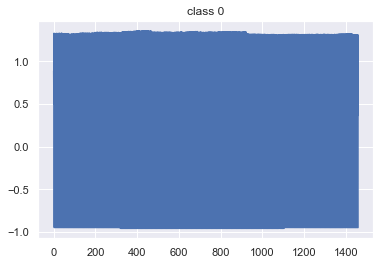

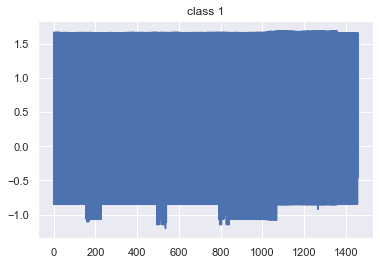

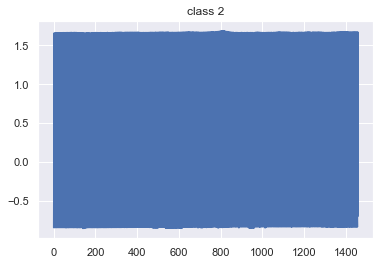

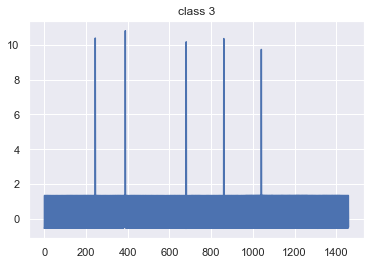

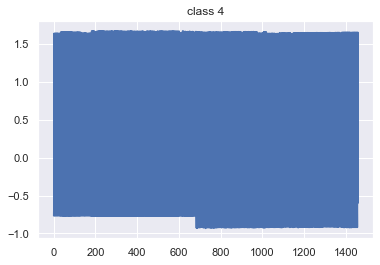

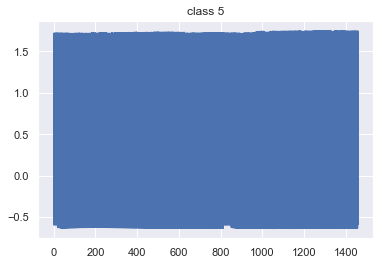

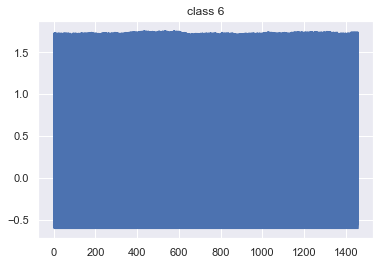

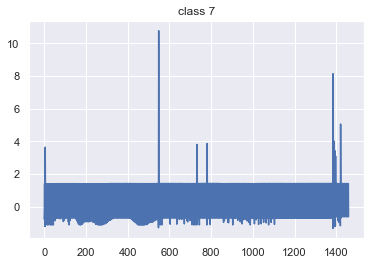

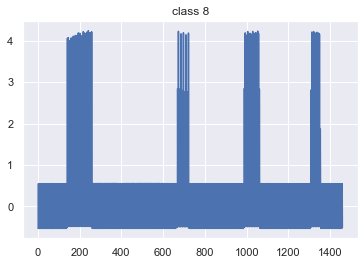

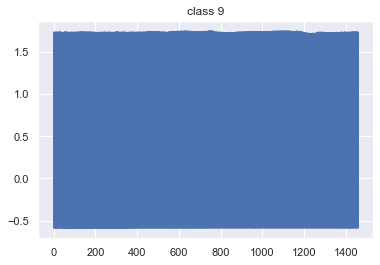

In [26]:
# Show one example for each class
labels, counts = np.unique(y_train, return_counts=True)
for label in labels:
    
    X_train.loc[y_train == label, "dim_0"].iloc[0].plot( label=f"class {label}")
    plt.title(f"class {label}")
    plt.show()



### 1.E 7pts Each observation is 10 seconds apart. Describe what the plots show for classes 3, 8 and 9. Give some intuition about what appliance each of these three classes might represent.
- Based on the question's information that each observation is 10 second apart, we calculate that for a total of 1460 observations the total time period is about 243.33 minutes!
- Class 3 has 5 spikes of energy consumption, each spike is about 10 units (the average consumption is closer to 1.5 units). The spikes do not last very long in time, perhaps only 1-2 observations (10-20 seconds) per spike. I imagine this severe and brief spike to be a consumption pattern of a microwave. 
- Class 8 has 4 spikes or surges in consumption, each lasting varying time periods. The surge is about 4 units, which is much smaller than the spikes of class 3 previously. The surges seem to last a few minutes at a time, anywhere between 1 to 10 minutes. This consumption pattern could be attributed to a printer, coffee machine, or similar. 
- Class 9 has a consumption pattern that is clearly constant over the entire observation period. It does not spike or vary much overall. An appliance that may produce this consumption pattern is a freezer/fridge.

## Part 2: 15 pts Description of Time Series Classification models

### 2.A. 5 pts Select one classification model type. Describe how the model works. Why would each be a good or bad fit for this type of data?
- A SHAPELET transform algorithm can analyze the time series subsequences and generate output useful to a classifier to discriminate classes. The concept behind shapelet is that time series data often exhibits characteristic data shapes that are indicative of the class of the time series. 
- The way it works is that time series data is passed through a shapelet algorithm that produces output showing a minimum distance measure between the shapelet and all subsequences in the data set. As such, it is a type of distance-based algorithm that is similar to DTW except that the shapelet transform only measures the distance for subsequences of the data and not the entire time series. 
- Shapelets can provide interpretable results, which may help domain practitioners better understand their time series data. Shapelets can also be significantly more accurate/robust on some datasets. This is because they are local features, whereas most other state-of-the-art time series/shape classifiers consider global features, which can be brittle to even low levels of noise and distortions. 
- Shapelets would not be a good fit for this model because there are many classes that have similar consumption patterns. For example, class 6 and 9. We should have more variation in the patterns to use this approach

### 2.B 5 pts Select a second classification model type. Describe how the model works. Why would each be a good or bad fit for this type of data?
- Another popular type of classifier algorithms is based on the structure of a dictionary, which is used to describe the meaning of a work in the most common use of the term. However, a dictionary approach can describe objects other than words. A dictionary could also be used to describe the number of occurrences (frequency) of a particular shapelet in a time series.
- A structure very similar to a shapelet, called a kernel, is used in pattern analysis and can be the source of the dictionary for subsequent classification.
- For text classification, a highly useful dictionary approach is the Bag-of-Words (BoW) algorithm that counts the occurrence of words within a document, and this information is then used to train a BoW model. The intuition here is that documents are similar if their features (word counts) are similar. 
- A similar approach that can be used on time series data uses the Bag-of-Patterns (BoP) algorithm that, instead of counting words, looks at the amplitude of a time series signal within some specified window of the data and applies a simple transformation to the signal to represent the mean of the signal within the window. This feature then becomes the basis for the dictionary that is used to train a classifier.

### 2.C. 5 pts Select third classification model type. Describe how the model works. Why would each be a good or bad fit for this type of data?
- A distance measure is an objective score that summarizes the relative difference between two objects in a problem domain. The smaller the distance measure between two objects (typically data describing something), the more similar the items are. Some types of distance measures that are typically used in machine learning are Euclidian distance, Hamming, Manhattan, and Minkowski distance.
- These distance measurements are used along with some well-known distance-based algorithms such as k-nearest neighbors (KNN). It measures the distance between the test object and all of the objects in the training data set. The k shortest distances are then selected, and the new object is assigned the class that is most represented in the k objects from the training set. When k is set to one, the algorithm reduces to the one-nearest neighbor, and the test object is assigned the class of the training set sample with the shortest distance.
- KNN is good for predicting this particular dataset, as it would try to match those that have similar pattern even though they don't align exactly. It is simple and robust. A disadvantage is that it is slow to compute since KNN requires DTW to compare each object with all the other objects.

## Part 3: 50 pts Select one method. Model and examine results

### 3.A. 10 pts Select only one method. Fit your model. Feel free to adjust parameters or try a grid search (optional)

In [29]:
from sklearn.model_selection import train_test_split

In [34]:
X, y = load_acsf1(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, [0]], y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(150, 1) (150,) (50, 1) (50,)


In [35]:
X_train.head()

,dim_0
27,0 -0.946175 1 0.529311 2 1.31...
19,0 -0.585158 1 2.319553 2 1.31...
41,0 -0.611784 1 -0.509734 2 1.72...
2,0 -0.577945 1 -0.577945 2 1.73...
82,0 -0.711383 1 -0.302802 2 1.54...


In [36]:
y_train[:5]

array(['4', '3', '6', '9', '7'], dtype='<U1')

In [37]:
X_train['dim_0'][0]

0    0      -0.577967
1      -0.577967
2       1.73...
0    0      -0.584754
1      -0.584754
2       1.73...
Name: dim_0, dtype: object

In [38]:
type(X_train['dim_0'][0])

pandas.core.series.Series

In [39]:
# examine distribution of classes
labels, counts = np.unique(y_train, return_counts=True)
print(labels, counts)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9'] [17 14 15 11 17 14 16 15 13 18]


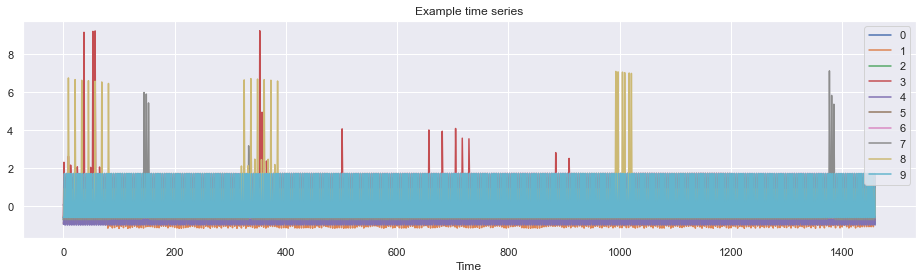

In [40]:
# Plot 1 example of each class
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for label in labels:
    X_train.loc[y_train == label, "dim_0"].iloc[0].plot(ax=ax, label=label)
plt.legend()
ax.set(title="Example time series", xlabel="Time");

In [56]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsTimeSeriesClassifier(n_neighbors=3, distance='dtw')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_pred_train = knn.predict(X_train)

### 3.B 10 pts Return the accuracy score of the train set and test set (suggestion to use .score()). Print the confusion matrix and classification report of the test set.

In [57]:
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score(y_pred, y_test))

0.7533333333333333
0.52


In [62]:
import pandas as pd
print(pd.DataFrame({'preds': y_pred,'test': y_test}))

   preds test
0      8    3
1      1    1
2      8    8
3      2    1
4      7    3
5      5    7
6      6    6
7      9    5
8      2    2
9      8    8
10     1    1
11     9    9
12     2    7
13     6    6
14     1    2
15     7    3
16     9    3
17     8    8
18     8    8
19     7    3
20     5    7
21     4    4
22     2    0
23     3    3
24     8    3
25     6    5
26     6    6
27     5    5
28     2    4
29     2    2
30     0    0
31     1    1
32     1    5
33     9    9
34     5    7
35     6    8
36     5    2
37     7    7
38     9    8
39     5    5
40     8    3
41     3    3
42     6    6
43     8    8
44     5    4
45     2    2
46     2    1
47     1    0
48     1    1
49     5    5


In [63]:
print(pd.DataFrame({'preds_train': y_pred_train,'test': y_train}))

    preds_train test
0             4    4
1             3    3
2             6    6
3             9    9
4             2    7
..          ...  ...
145           7    3
146           9    5
147           6    6
148           4    4
149           1    4

[150 rows x 2 columns]


In [48]:
from sktime.classification.interval_based import RandomIntervalSpectralEnsemble
from sklearn.metrics import classification_report, confusion_matrix
rise = RandomIntervalSpectralEnsemble(n_estimators=100, acf_lag=10)
rise.fit(X_train, y_train)

RandomIntervalSpectralEnsemble(acf_lag=10, n_estimators=100)

In [49]:
print( confusion_matrix(y_test, rise.predict(X_test)) )
print( classification_report(y_test, rise.predict(X_test)) )

[[3 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 3 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 4 0]
 [0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 1]
 [0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 1 0 0 0 0 6 0]
 [0 0 0 0 0 0 0 0 0 2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.50      0.67         6
           2       1.00      1.00      1.00         5
           3       0.83      0.56      0.67         9
           4       0.50      1.00      0.67         3
           5       1.00      0.83      0.91         6
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         5
           8       0.60      0.86      0.71         7
           9       0.67      1.00      0.80         2

    accuracy                           0.82        50
   macro avg       0.86      0.87      0.84        50
weighted avg       0.87      0.82      0.82        50



### 3.C. 10 pts Discuss the precision score for class 8. Support this with your visual opinion from plots in 1D as well as the confusion matrix.
- Precision score in this class 8 is 0.60. This means that only 60% of those series for appliances belonging to the class were classified correctly. We know that precision is the ratio of correct positive predictions to the total predicted positives.
- Looking at the graphs from 1D, it does not look much at all like the graphs it was incorrectly predicted (class 1 and 6)
- The confusion matrix mistakenly classified 4 class 8 as class 3. We know that the bottom-left of the diagonal is false negatives, and the top right of the diagonal is false positives.

### 3.D. 10 pts Discuss the recall score for class 5. Support this with your visual opinion from plots in 1D as well as the confusion matrix.
- Recall score in this class 5 is 0.83. This means that only 83% of those series belonging to the class were classified correctly. 
- Looking at the graphs from 1D, it looks very similar to class 6 and 1. 
- The confusion matrix mistakenly classified 1 class 5 samples as class 9.

### 3.E. 10 pts Which metric do you feel is the most important in the following business case: You work for ComEd, a local electricity supplier. You head a department that uses analytics to plan electrical supply for Chicago's power grid. Assume that your department budgets for a certain amount of electrical supply at a fixed low rate. If the total demand in Chicago stays within the purchased supply levels, your department is performing. If the demand breaches this supply level, the company is penalized and the rate for your supply multiplies by 100x, destroying your department’s performance. If you had to build your forecast model to classify patterns of high electrical usage (appliances, air conditioning, water heating) vs low electrical usage (lighting, tv, phone chargers) which metric (precision or recall) would you use?
- Since we are severely penalized everytime our department overshoots our electrical supply, then we should be building our forecast model to classify patterns of electrical usage based on recall.
- Generally, Recall is more important where overlooked Cases (False Negatives) are more costly than False Alarms (False Positive). We are clearly valuing overlooked cases more than false alarms in our business case because our penalty is based on whether we can minimize overlooked cases! Conversely catching many false alarms will not harm us because a false alarm would still mean total demand is staying within the purchased supply levels.
- Precision is not more important because we do not care necessarily about how accurate our predictions are for consumption patterns of certain appliances. We care much more about how accurate we are in terms of never overlooking high electrical usage!
- To fully evaluate the effectiveness of a model, we must examine both precision and recall. Unfortunately, we have to only choose one. Precision and recall are also often in tension. That is, improving precision typically reduces recall and vice versa. 